# Exercise 3 - DQN (26 points)
In this exercise we will train our own agent using [Deep Q Networks (DQN)](https://arxiv.org/pdf/1312.5602.pdf) to solve the tasks from [MinAtar](https://github.com/kenjyoung/MinAtar). Last time we looked at tabular Q-learning, which learns Q-values from sampled experience and stores its estimates in a table.  For high-dimensional problems, however, tabular methods become impractical, and we use function approximators such as neural networks instead.The DQN is a popular deep reinforcement learning method that does just that.It is based on Q-learning and uses deep neural networks as function approximators.

<img src="breakout.gif" alt="MinAtar" width="20%"/>


_Agent using random actions to play MinAtar Breakout_

## 0 Setup
These are the same packages as in the last exercise:

In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## 1 Deep Q-Networks
In Q-learning, we have the following update:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max_{a'}Q(s', a') - Q(s, a))$

with discount factor $\gamma$, learning rate $\alpha$, reward $r$, sampled state $s$, sampled next state $s'$ and sampled action $a$.Instead of a table, we will now use a neural network to represent the Q-function $Q(s, a; \theta)$, where $\theta$ are the parameters of the neural network. In order to learn the Q-function, we minimize the Mean Squared Error loss between our current estimate and our TD target using Stochastic gradient descent (SGD):

$ L(\theta) = \mathop{{}\mathbb{E}}_{(s, a, r, s') \sim D}([r + \gamma \max_{a'}Q(s', a'; \theta') - Q(s, a; \theta)]^2 )$  

where D is a dataset of sampled transitions and $\theta'$ are old parameters. This is very similar to how we train in a supervised learning setting!

---
<span style="color:orange">**EXERCISE**</span>: **DQN Warm-up** (5.5 points)
1. In the Q-update above, which part is the TD target and which one is the TD error? 
2. Given a neural network with one linear layer and a ReLU activation. Describe the parameters $\theta$ of this network.
3. Explain the difference between on and off-policy learning in RL. Q-learning is considered off-policy, why?
4. In machine learning, we assume that the samples of our data set are independent and identically distributed (i.i.d.). What do we mean by this?
5. What are minibatches and why are they used?

**Your answers:**

1. TD target: $r + \gamma \max_{a'}Q(s', a')$ (0.5 points) TD error: $\text{TD target} - Q(s, a)$ (0.5 points)
2. $\theta = (W, b)$ with $W$ as the weight matrix and $b$ as the bias vector of the linear layer, which calculates $Wx + b$ with $x$ as input. (1 point)
3. In on-policy RL, the policy for sampling experience, called behavior policy, and the policy for training, called target policy, are the same, while in off-policy they are not. (1 point)
Q-learning is off-policy because the behavior policy has some kind of exploration, e.g., epsilon-greedy, and is different from the target policy, which is completely greedy, as can be seen in the TD target, which takes the greedy action as the next action. (0.5 points)
4. A property of multiple random variables $X_1, X_2, ..$ where all variables are independent of each other and from the same distribution. (1 point)
5. A subset of the data set used for training as gradient estimation of the whole data set can be time and memory consuming, while minibatches are faster to compute and often accurate enough. (1 point)

## 1.1 Q-Network

Since we are representing our Q-function as a deep neural network, we will first define it using PyTorch. Then we will define the epsilon greedy policy and introduce how to decay the epsilon over time.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the Q-Network** (3 points, -0.5 for every mistake)

In the DQN paper, the network structure used is described as follows (although we have changed the hyperparameters!):
> The input to the neural network consists [..] [of] an 10 × 10 × n image [...]. The first hidden layer convolves 16 5 × 5
> filters with stride 1 with the input image and applies a rectifier nonlinearity. The second 
> hidden layer convolves 32 3 × 3 filters with stride 1, again followed by a rectifier nonlinearity. The
> final hidden layer is fully-connected and consists of 128 rectifier units. The output layer is a fully-
> connected linear layer with a single output for each valid action.

>
> <cite>from [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf) (Mnih et al., 2013)</cite>

Implement this architecture.

In [2]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.
        
        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        # obs_shape is the shape of a single observation -> use this information to define the dimensions of the layers
        super(DQN, self).__init__()

        # TODO: your code
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: your code
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        # As several students have not understood it this way, no points are deducted for missing the last activation
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out


We import the epsilon greedy policy from our previous exercise. Note that we made some changes because Q is a network and epsilon is no longer fixed.

In [3]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [4]:
def make_softmax_policy(Q: nn.Module, num_actions: int):
    """
    Creates a softmax policy based on a given Q-function.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns an action with probability
              proportional to the exponentiated Q-values of the actions.
    """
    
    def policy_fn(obs: torch.Tensor, tau: float = 1.0):
        """
        This function takes in the observation and the temperature parameter tau,
        and returns an action based on a softmax distribution of Q-values.
        """
        q_values = Q(obs)
        probabilities = torch.nn.functional.softmax(q_values / tau, dim=-1)

        action = torch.multinomial(probabilities, 1).item()
        return action

    return policy_fn

At the beginning of training we want high exploration, while towards the end we want high exploitation instead. As we use $\epsilon$-greedy we can influence this tradeoff using the parameter of $\epsilon$. However, setting it to a constant value will not have the desired effect, so we want to start at a high value and decrease it over time.

---
<span style="color:orange">**EXERCISE**</span>: **Linear $\epsilon$-decay** (1.5 points, -0.5 for every mistake)

Implement a linear decay function for $\epsilon$, taking the start and end values as inputs. The function returns the current $\epsilon$ based on the current time step and the duration. So after half the time has passed, the value of $\epsilon$ should also be halfway between the start and end values.

In [5]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

In [6]:
import math


def exponential_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Exponential decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """
    if current_timestep >= duration:
        return eps_end

    decay_rate = -math.log(eps_end / eps_start) / duration
    epsilon = eps_end + (eps_start - eps_end) * math.exp(-decay_rate * current_timestep)

    return epsilon

Check that the linear epsilon decay works as intended. Your function should start at $\epsilon=1.0$ and decrease linearly until it reaches time step $600$, where it reaches its final value of $\epsilon=0.2$ and remains constant.

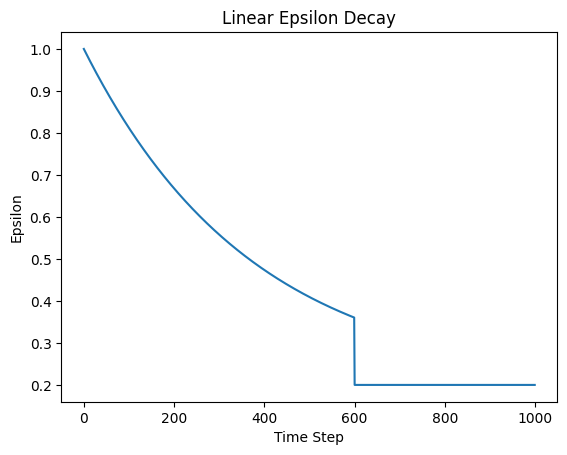

In [7]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

# In case of exponential epsilon decay it will not decrease linearly, because of the nature of this decay.
eps_values = [exponential_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()


## 1.2 Target Network and Replay Buffer
As described before, the main idea behind DQN is simple, we just minimize the MSE between the TD-target and the current estimate using the transitions we sampled. However, there are two problems that make the method very unstable:

- **Non-stationary target**: The TD-target uses an estimate from our Q-network. Unlike supervised learning, this target is not fixed, and whenever we update our network parameters, the target changes as well.
- Sampled transitions are **correlated** (each transition depends on the last transition if both are from the same episode). Samples are not independent.

DQNs addresses both problems by using

- **Target network:**
An older set of network parameters is stored to compute the TD target, so they change less frequently and this improves stability. We call this network the target network. Its parameters are updated every few iterations.
- **Experience Replay:**
A buffer where all transitions are stored and randomly sampled to make the data distribution more stationary. The buffer has a fixed size and new samples overwrite old ones.

First we look at the target network:

In [8]:
test_input = torch.tensor([1, 2, 3, 4], dtype=torch.float32)

# Given a neural network
net = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(), 
    nn.Linear(3, 1)
)
print(f"Prediction (Before): {net(test_input)}\n")

# We can get its parameters with .state_dict(). A dictionary containing all the parameters.
# Note: It contains even more than parameters, but that is not relevant for us.
params = copy.deepcopy(net.state_dict())

print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Set weight matrix of first layer to zero
net[0].weight.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Load the old parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")


Prediction (Before): tensor([0.5540], grad_fn=<ViewBackward0>)

Parameters:
- Parameter 0.weight:
tensor([[-0.4444, -0.0864, -0.0321, -0.0941],
        [-0.3569, -0.4928, -0.1432,  0.0047],
        [-0.0817, -0.2453,  0.3169,  0.4794]])
- Parameter 0.bias:
tensor([-0.3857, -0.0481, -0.4059])
- Parameter 2.weight:
tensor([[-0.5410, -0.4946,  0.2342]])
- Parameter 2.bias:
tensor([0.1113])

Prediction (After change): tensor([0.1113], grad_fn=<ViewBackward0>)

Prediction (After reload): tensor([0.5540], grad_fn=<ViewBackward0>)



So we can save and load old parameters of our network using ``.state_dict()`` and ``.load_state_dict(..)`` respectively.

---
<span style="color:orange">**EXERCISE**</span>: **Implement the Replay Buffer** (4 points, -0.5 for every mistake)

The replay buffer stores transitions of the form $(s, a, r, s')$ with $s$ as the current state, the action $a$, the reward $r$, and the next state $s'$. The buffer can perform two operations:
- **store**: During sampling we observe transitions and store them with ``buffer.store(...)``. However, the buffer only has a fixed size
(as we cannot store an infinte amount of data). When reaching it, the oldest samples are overwritten first.
- **sample**: For training, we want to sample a batch of transitions from our buffer via ``buffer.sample(...)``. The transitions are sampled uniformly and with replacement i.e. the same transition can be sampled more than once.

In the following, implement the replay buffer by filling in the missing code and implementing both functions.


In [9]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        # TODO: Your code
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        # TODO: Your code
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size         

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        # TODO: Your code 
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

---
<span style="color:orange">**EXERCISE**</span>: **Replay Buffer** (2 points)

1. Suppose we have only one transition in the replay buffer and we are now sampling a batch of 16 samples. What happens and why might this be problematic for training?
2. Imagine storing $100,000$ observations of the form $10 \times 10 \times 4$ with $32$ bits per entry. How many megabytes of memory will this require?


**Your answers:** 
1. The same transition would be sampled 16 times. Since we assume independence of our samples for training, the updates will overfit to the few examples provided if the number of stored transitions remains small. (1 point)
2. $(100,000 \times 10 \times 10 \times 4 \times 32) / (8 \times 1000 \times 1000) = $160 MB. (1 point)

## 1.3 Algorithm
In this section, we will first look at the update of the DQN and then implement the entire algorithm.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the DQN Update** (3 points, -0.5 for every mistake)

Write the function ``update_dqn``, which gets the sampled data from the replay buffer, calculates the DQN loss and performs an update step.

In [10]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    # TODO: Calculate the TD-Target
    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()


We are now putting it all together. This implementation is very similar to the Q-learning one. Note that we have not specified an environment yet! Our algorithm remains relatively flexible.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the DQN Agent** (3.5 points, -0.5 for every mistake)

Implement the DQN agent by filling in the missing gaps in the code.

In [11]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgentExponentialEpsilonDecay:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        # TODO: Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_softmax_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # TODO: Get current epsilon value
                epsilon = exponential_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), tau=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                # TODO: Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

## 1.4 Training
Now, we want to run our algorithm on a task in [MinAtar](https://github.com/kenjyoung/MinAtar). You are free to choose any environment you like, however, we recommend Breakout-v1 as the other environments may need different hyperparameters and more training time. The following game ID's are available: SpaceInvaders-v1, Breakout-v1, Seaquest-v1, Asterix-v1 and Freeway-v1.
Note, that the training can take several minutes.

In [ ]:
# Choose your environment
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 20_000
NUM_EPISODES = 500
DISCOUNT_FACTOR = 0.99

# Train DQN
agent = DQNAgentExponentialEpsilonDecay(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

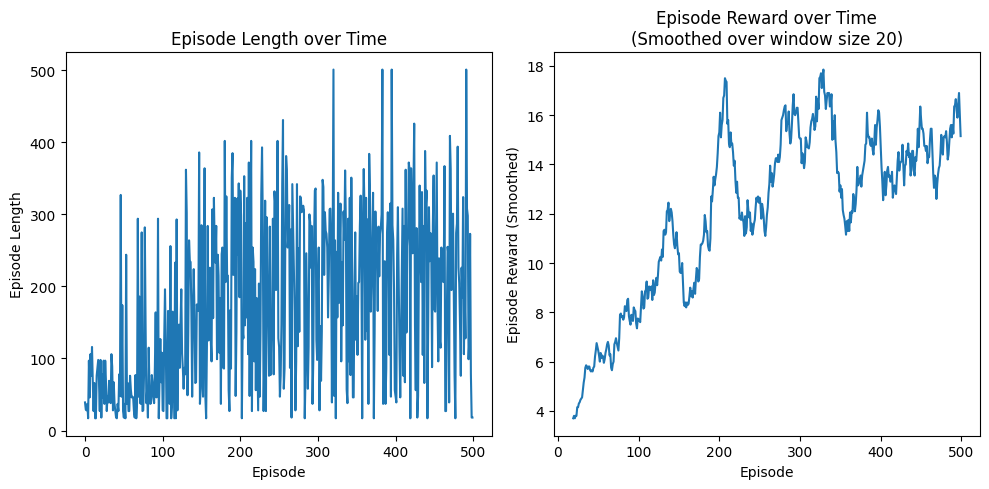

In [12]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

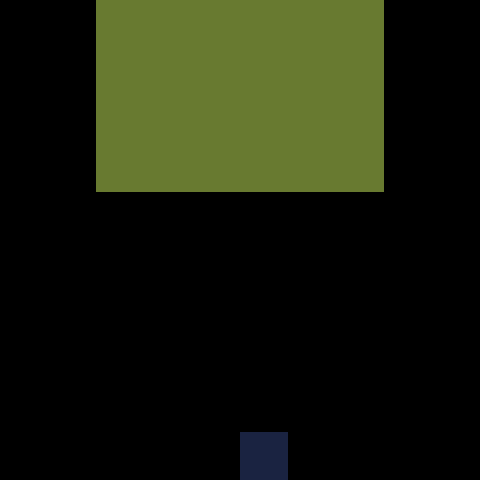

In [28]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_softmax_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained_exponential_epsilon_decay.gif")
IImage(filename="trained_exponential_epsilon_decay.gif")

In [12]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgentLinearEpsilonDecay:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        # TODO: Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_softmax_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # TODO: Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), tau=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                # TODO: Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [13]:
# Choose your environment
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 500
DISCOUNT_FACTOR = 0.99

# Train DQN
agent = DQNAgentLinearEpsilonDecay(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Episode 100 of 500  Time Step: 8982  Epsilon: 0.231
Episode 200 of 500  Time Step: 25532  Epsilon: 0.050
Episode 300 of 500  Time Step: 47904  Epsilon: 0.050
Episode 400 of 500  Time Step: 70454  Epsilon: 0.050
Episode 500 of 500  Time Step: 94807  Epsilon: 0.050


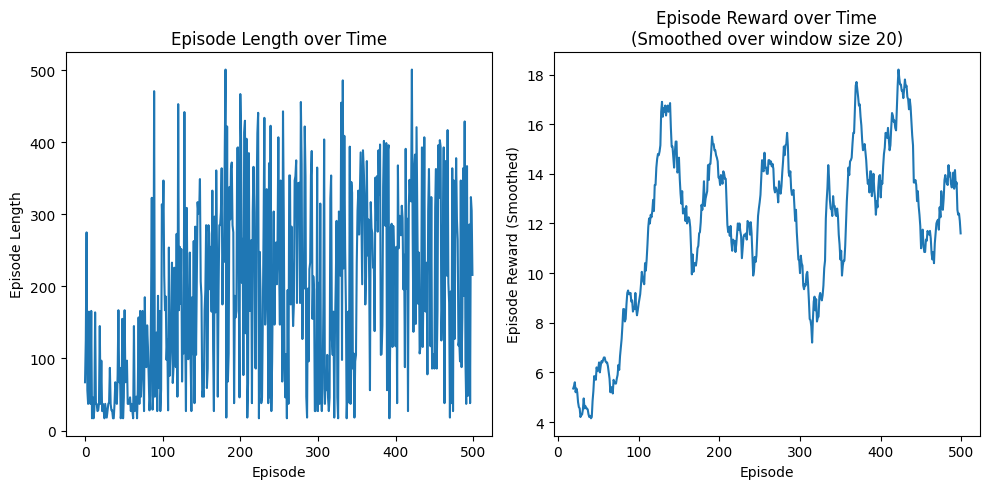

In [12]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

/Users/martagulida/opt/anaconda3/envs/rl_lab/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/Users/martagulida/opt/anaconda3/envs/rl_lab/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


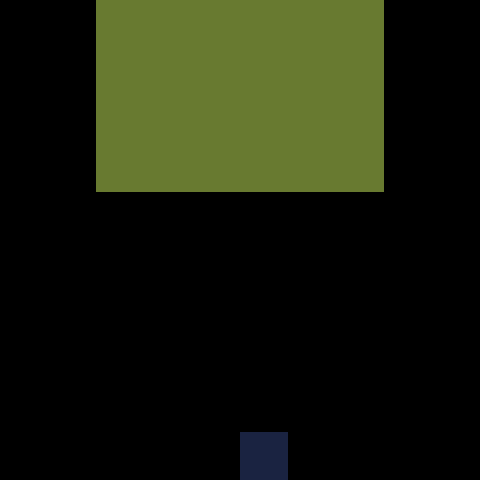

In [13]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_softmax_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained_linear_epsilon_decay.gif")
IImage(filename="trained_linear_epsilon_decay.gif")

We did not train very far because it can be very time-consuming.

---
<span style="color:orange">**EXERCISE**</span>: **The deadly triad** (2 points)

In Sutton and Barto's "Reinforcement Learning: An Introduction" they introduced the concept of the **Deadly Triad**. Investigate this concept and explain in your own words what it describes. What does it say about DQNs?

**Your answers:**

RL methods based on function approximation, bootstrapping, and off-policy training can be unstable and diverge. For example, our value function represented by a function approximation may assign the same value to different states because they have a similar feature representation. Due to off-policy learning, the states may not be visited often enough to correct this error. Furthermore, as we bootstrap, these incorrect value estimates are used to estimate values of other states as well. This can lead to complete divergence of our method. (1.5 points) Since DQN combines all elements, stable training is not guaranteed. (0.5 points)


---
<span style="color:orange">**EXERCISE**</span>: **Going beyond discrete action spaces** (1.5 points)

1. What is the difference between an discrete and continuous action space?
2. Name a key problem that may arise by using DQN for continuous action spaces. Hint: Think about how we select a greedy action.

**Your answers:**
1. A discrete action space has a finite number of actions, while a continuous action space has an infinite number of actions (0.5 points).
2. Since the number of actions is infinite, we cannot easily determine the maximum over the Q-values of the next state $max_{a'}Q(s', a')$. Nonlinear optimization methods would be required, which could be computationally expensive.(1 point)